In [1]:
import torch
import cv2
import torchvision.transforms as transforms
import argparse

In [2]:
def draw_bboxes(image, results, classes_to_labels):
    for image_idx in range(len(results)):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        orig_h, orig_w = image.shape[0], image.shape[1]
        bboxes, classes, confidences = results[image_idx]

        for idx in range(len(bboxes)):
            x1, y1, x2, y2 = bboxes[idx]
            x1, y1 = int(x1*300), int(y1*300)
            x2, y2 = int(x2*300), int(y2*300)
            
            x1, y1 = int((x1/300)*orig_w), int((y1/300)*orig_h)
            x2, y2 = int((x2/300)*orig_w), int((y2/300)*orig_h)
            
            cv2.rectangle(
                image, (x1, y1), (x2, y2), (0, 0, 255), 2, cv2.LINE_AA
            )
            
            cv2.putText(
                image, classes_to_labels[classes[idx]-1], (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2
            )
            
    return image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [5]:
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
ssd_model.to(device)
ssd_model.eval()
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
image_path = "/content/v7w_22.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transformed_image = transform(image)
tensor = torch.tensor(transformed_image, dtype=torch.float32)
tensor = tensor.unsqueeze(0).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


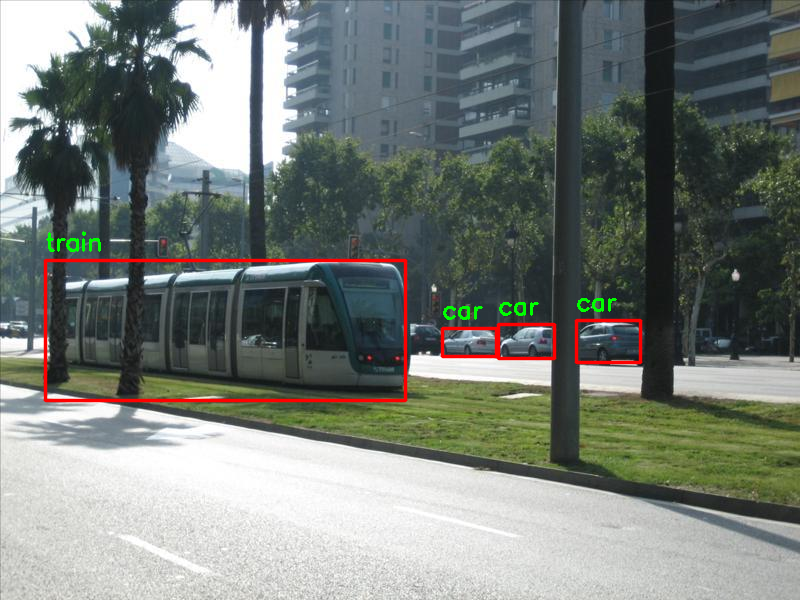

In [8]:
from google.colab.patches import cv2_imshow

#Run inference
with torch.no_grad():
    detections = ssd_model(tensor)

results_per_input = utils.decode_results(detections)

best_results_per_input = [utils.pick_best(results, 0.6) for results in results_per_input]

classes_to_labels = utils.get_coco_object_dictionary()

image_result = draw_bboxes(image, best_results_per_input, classes_to_labels)
cv2_imshow(image_result)